In [4]:
import utils, shapely_utils as shu, python_utils as pu, cairo_utils as cu
from shapely import LineString, MultiLineString, GeometryCollection
import shapely as sh
import numpy as  np
import bezier

In [3]:
pip install pycairo

     -------------------------------------- 841.5/841.5 kB 2.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
radius = 0.5
first = shu.Circle((0,0),radius)

In [6]:
def random_point_line(line):
    import random
    return line.interpolate(line.length*random.random())


In [7]:
def follow_line(line, distance, starting_point=None):
    if starting_point is None:
        starting_point = shu.first(line)
    return starting_point+shu.unit_vector(line)*distance

In [8]:
golden_angle = (180*(3-5**0.5))
golden_angle

137.50776405003785

In [13]:
pu.reload(pu)

In [14]:
import random
number_of_circles = 6
radius = 5
last_circle = shu.Circle((0,0),radius)
last_line = LineString([last_circle.centroid,shu.first(last_circle)])
circles = [last_circle]
points = [last_circle.centroid]
for i in range(number_of_circles):
    last_circle = sh.affinity.rotate(last_circle,golden_angle*i)
    a = shu.first(last_circle)
    half_line = LineString([a,last_circle.centroid])
    b = follow_line(half_line,half_line.length*2)
    new_line = LineString([a,b])
    # new_line = sh.affinity.rotate(new_line, golden_angle,  )
    # points.append(new_line)
    random_distance = 0.35 #random.random()
    sliced_line = shu.sliceLine(new_line, 0.5, 1)
    random_point = shu.interpolateTotal(sliced_line,random_distance)
    points.append(random_point)
    radius = 0.5*new_line.length+random_distance*sliced_line.length
    new_circle = shu.Circle(random_point, radius)
    circles.append(new_circle)
    last_circle = new_circle
rose = shu.printg(*(circles))


In [205]:
aw = pu.DotMap()
aw.rose = rose

In [72]:
def get_tolerance(line, point):
    for tolerance in np.arange(0,20,0.1):
        if line.buffer(i).intersects(point):
            return tolerance
    

In [117]:
shu.coords(shu.segmentize(LineString([[0,0],[1,1]]),10))

NotImplementedError: Sub-geometries may have coordinate sequences, but multi-part geometries do not

In [126]:
def filter_tangent_condition(ref, condition = lambda x,y:True, segmentize=None):
    if not segmentize is None:
        ref = ref.segmentize(segmentize)
    points = [sh.Point(c) for c in shu.coords(ref)]
    slopes = [((second.y-first.y),(second.x-first.x)) for first, second in pu.iter_two(points)]
    filter_slope = condition
    slope_index_selected = []
    is_currently_ok = False
    starting_point = None
    for i,x_y in enumerate(slopes):
        x,y=x_y
        is_i_ok = filter_slope(x,y)
        if (is_i_ok):
            if (is_currently_ok):
                pass
            else:
                starting_point = i
                is_currently_ok = True
        elif (is_currently_ok):
            slope_index_selected.append((starting_point, i))
            starting_point = None
            is_currently_ok = False
        else:
            pass
    if is_currently_ok:
        slope_index_selected.append((starting_point, i))
    from shapely.ops import split
    # snapped_points = [sh.snap(p, ref, tolerance) for p in points]
    geos_ok = []
    for i,j in slope_index_selected:
        splitted = split(ref, sh.MultiPoint([points[i],points[j]])).geoms
        if len(splitted)==1:
            print('splitting none')
        if len(splitted)!=3:
            print('error!')
        else:
            geo_ok = splitted[1]
            geos_ok.append(geo_ok)
    return MultiLineString(geos_ok)

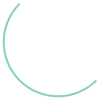

In [107]:
filter_tangent_condition(circles[0], condition = lambda x,y:x-y>0, tolerance=3)

In [ ]:
def sliceLineLength(g, startLength, endLength=1):
    start_p = g.interpolate(startLength)
    end_p = g.interpolate(endLength)
    return LineString([start_p, end_p])

In [206]:
new_geo = []
for circle in circles:
    circle2 = filter_tangent_condition(circle, condition = lambda x,y:x-y>0, )
    circle2_merge = sh.line_merge(circle2)
    circle2_merge = circle2_merge.segmentize(3)
    lines = [sliceLineLength(LineString([c, aw.rose.centroid]), 0,0.1) for c in shu.coords(circle2_merge)]
    new_geo.append(GeometryCollection(lines))

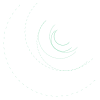

In [207]:
geo_shadow = shu.print(new_geo)
geo_shadow

In [208]:
colored = {
    'shadow':"black",
    'rose': 'red',
    'background': 'green'
}

In [209]:
geo_shadow = shu.print(new_geo)
# scale = 0.9
# translate = 0.1
# geo_shadow = sh.affinity.scale(geo_shadow,scale,scale, 1, aw.rose.centroid)
# geo_shadow = sh.affinity.translate(geo_shadow,translate,translate)
# aw.shadow = geo_shadow

In [210]:
cu.create_artwork(aw,colored, 0.2,0.1, 'svg')

In [227]:
def start_at_0(geometry):
    bounds = geometry.bounds
    translate_x = abs(min(bounds[0],0))
    translate_y = abs(min(bounds[1],0))
    geometry_translated = sh.affinity.translate(geometry, translate_x,translate_y)
    return geometry_translated

In [228]:
def resize(geo, new_size, maintain_proportion=True,):
    w,h = shu.size(geo)
    prop_w, prop_h = new_size[0]/w, new_size[1]/h
    if prop_w>1 and prop_h<1 or prop_w<1 and prop_h>1:
        print('cant')
        return geo
    if maintain_proportion:
        if prop_w>1:
            max_w_h = max(prop_w,prop_h)
            prop_w = max_w_h
            prop_h = max_w_h
        if prop_w<1:
            min_w_h = min(prop_w,prop_h)
            prop_w = min_w_h
            prop_h = min_w_h
    return sh.affinity.scale(geo,prop_w,prop_h, )

In [ ]:
def translate_all_layers()

In [ ]:
def plot_grid(geo, padding, rows=1, cols=1):
    padding_top,padding_right,padding_bottom,padding_left=padding
    start_geo = sh.affinity.translate(geo, padding_top, padding_right)
    current_x, current_y = (0,0)
    for i in range(0,rows):
        current_y += padding_top
        for j in range(0,cols):
            current_x += padding_right
            geo
            current_y += padding_left

In [ ]:
def padding(geo,padding_top=0,padding_right=0,padding_bottom=0,padding_left=0):
    return 

In [229]:
resize(start_at_0(aw.rose), ).bounds

TypeError: resize() missing 1 required positional argument: 'new_size'

In [226]:
shu.size(resize(g,(1,1)))

(0.5, 1.0)

In [199]:
sh.snap()

TypeError: snap() missing 3 required positional arguments: 'geometry', 'reference', and 'tolerance'

In [ ]:
# def autotolerance(line,number_points):
#     pass
    

In [ ]:
from shapely.ops import split

# shu.printg(a,p.buffer(1))

In [ ]:
slope_index_selected

In [ ]:
a.segmentize()

In [ ]:
shu.size(rose)